In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from scipy import stats

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
data = pd.read_csv('credit_card_default_analysis.csv')

### Посмотрим на данные

In [5]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# 1. Размер кредитного лимита

### Проверьте гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

 $H_0\colon$ Медианы хороших и плохих клиентов равны.
 
 $H_1\colon$ Не равны.

In [6]:
data.default.value_counts()

0    23364
1     6636
Name: default, dtype: int64

In [7]:
good_clients = data[data['default'] == 0]
bad_clients = data[data['default'] == 1]

Text(0.5,1,'Плохие клиенты с просрочками ')

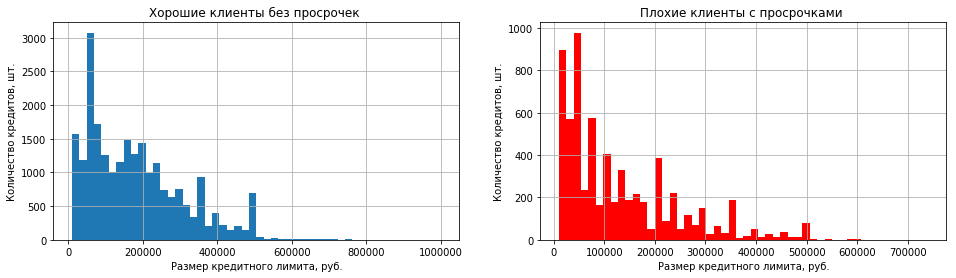

In [8]:
pylab.figure(figsize=(16, 4))
pylab.subplot(1, 2, 1)
good_clients.LIMIT_BAL.hist(bins = 50)
pylab.xlabel('Размер кредитного лимита, руб.')
pylab.ylabel('Количество кредитов, шт.')
pylab.title('Хорошие клиенты без просрочек ')

pylab.subplot(1, 2, 2)
bad_clients.LIMIT_BAL.hist(bins = 50, color = 'red')
pylab.xlabel('Размер кредитного лимита, руб.')
pylab.ylabel('Количество кредитов, шт.')
pylab.title('Плохие клиенты с просрочками ')

Прежде, чем расчтывать доверительные интервалы, проверим распределение на нормальность, используя критерий Шапиро-Уилка:

 $H_0\colon$ размер кредитного  лимита хороших клиентов распределен нормально
 
 $H_1\colon$ не нормально.

In [9]:
print ("Тест Шапиро, W-statistic: %f, p-value: %f" % stats.shapiro(good_clients.LIMIT_BAL))

Тест Шапиро, W-statistic: 0.919726, p-value: 0.000000


/home/tahhu/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1309: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


$H_0\colon$ отклоняется, следовательно данные распределены не нормально. Для статистик (в .т.ч. медиан), о распределении которых нам ничего неизвестно, будем использовать bootstrap.

In [10]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [11]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [12]:
good_clients_credit_limits_median =list(map(np.median, get_bootstrap_samples(good_clients.LIMIT_BAL.values, 1000)))
bad_clients_credit_limits_median =list(map(np.median, get_bootstrap_samples(bad_clients.LIMIT_BAL.values, 1000)))

In [13]:
diff_median = list(map(lambda x: x[0] - x[1], zip(good_clients_credit_limits_median, bad_clients_credit_limits_median)))

In [14]:
print ("95% довер. интервал медианы кредитного лимита для хороших клиентов: ",  stat_intervals(good_clients_credit_limits_median, 0.05))
print ("95% довер. интервал медианы кредитного лимита для плохих клиентов:",  stat_intervals(bad_clients_credit_limits_median, 0.05))
print ("95% довер. интервал для разности медиан лимита для плохих и хороших клиентов:",  stat_intervals(diff_median, 0.05))

95% довер. интервал медианы кредитного лимита для хороших клиентов:  [150000. 150000.]
95% довер. интервал медианы кредитного лимита для плохих клиентов: [80000. 90000.]
95% довер. интервал для разности медиан лимита для плохих и хороших клиентов: [60000. 70000.]


Вывод: интервалы для медиан лимитов для хороших и плохих клиентов не пересекаются.
Доверительный интервал для разности медиан не содержит 0.
Гипотезу о равенстве медиан отвергаем.

### Проверьте гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. 


Для проверки воспользуемся критерием Манна-Уитни для независимых выборок.

 $H_0\colon$ Распределения кредитных лимитов хороших и плохих клиентов равны.
 
 $H_1\colon$ Не равны.

In [15]:
stats.mannwhitneyu(good_clients.LIMIT_BAL.values, bad_clients.LIMIT_BAL.values)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Pvalue получился очень маленький, следовательно мы можем отвергнуть  $H_0\colon$. 
Распределения кредитных лимитов для хороших и плохих клиентов не равны.

### Значимы ли полученные результаты с практической точки зрения ?

С практической точки зрения результаты значимы.

# 2. Пол

 ### Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. 

### a) с помощью доверительного интервала для разности средних

In [16]:
data_sex = pd.crosstab(data.default, data.SEX, margins=True)
data_sex.columns = ['Man', 'Woman',  'All']
data_sex.index = ['Pay', 'Not_pay', 'All']
data_sex = data_sex.T
data_sex

,Pay,Not_pay,All
Man,9015,2873,11888
Woman,14349,3763,18112
All,23364,6636,30000


Сравним долю женщин среди вернувших и не вернувших кредит:

#### Интервальная оценка долей

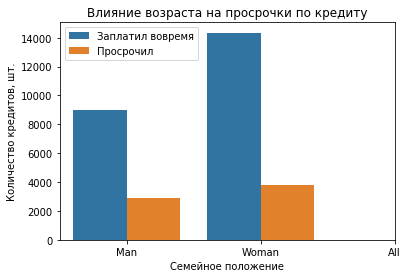

In [17]:
sns.countplot(x='SEX', hue='default', data=data);
plt.xlabel('Семейное положение')
plt.xticks(np.arange(len(data_sex.index)), ('Man', 'Woman',  'All'))
plt.ylabel('Количество кредитов, шт.')
plt.title('Влияние возраста на просрочки по кредиту')
plt.legend(['Заплатил вовремя', 'Просрочил'])

In [18]:
import scipy
from statsmodels.stats.weightstats import *
from statsmodels.stats.proportion import proportion_confint

In [19]:
good_woman_conf_interval = proportion_confint(data_sex.Pay['Woman'], 
                                            data_sex.Pay['Woman'] + data_sex.Not_pay['Woman'],
                                            method = 'wilson')
good_man_conf_interval = proportion_confint(data_sex.Pay['Man'], 
                                           data_sex.Pay['Man'] + data_sex.Not_pay['Man'],
                                            method = 'wilson')

print('Доля женщин, выплативших кредит:', good_woman_conf_interval)
print('Доля мужчин, задолжавших по кредиту:', good_man_conf_interval)

Доля женщин, выплативших кредит: (0.7862670348654015, 0.7980834091403679)
Доля мужчин, задолжавших по кредиту: (0.7505495900214224, 0.7659389640236883)


Интеравалы не пересекаются. Следовательно гендерный состав группы людей вернувших и не вернувших кредит отличается. Но для верности построим еще доверительный интервал для разности долей.

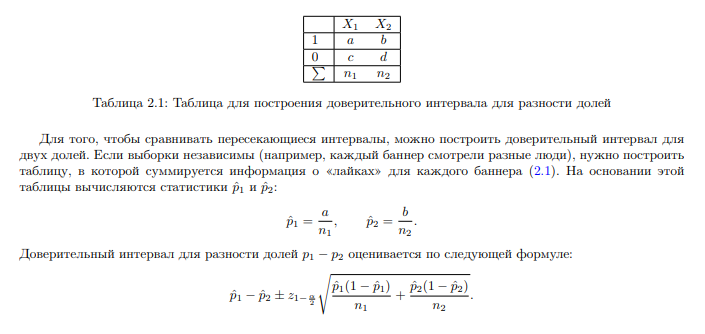

In [20]:
data_sex

,Pay,Not_pay,All
Man,9015,2873,11888
Woman,14349,3763,18112
All,23364,6636,30000


In [21]:
def proportions_confint_diff_ind(data_sex, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    a = data_sex.Pay['Woman']
    n1 = data_sex.Pay['Woman'] + data_sex.Not_pay['Woman']
    b = data_sex.Pay['Man'] 
    n2 = data_sex.Pay['Man'] + data_sex.Not_pay['Man']
    
    p1 = a / n1
    p2 = b / n2
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ n1 + p2 * (1 - p2)/ n2)
    
    return (left_boundary, right_boundary)

In [22]:
print('95% доверительный интервал разницы долей (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами:', proportions_confint_diff_ind(data_sex, alpha = 0.05))

95% доверительный интервал разницы долей (кредит без просрочек/кредит с просрочками) между мужчинами и женщинами: (0.02420737217979268, 0.04361155857081717)


Доверетельный интервал для разницы не содержит 0. Следовательно, гендерный состав группы людей вернувших и не вернувших кредит отличается (женщины немного ответсвеннее при выплате кредита). 
Но разница очень маленькая и практическая значимость сомнительна.

#### С помощью Z-критерий

In [23]:
# посчитаем Z критерий
def proportions_diff_z_stat_ind(data_sex):
    a = data_sex.Pay['Woman']
    n1 = data_sex.Pay['Woman'] + data_sex.Not_pay['Woman']
    b = data_sex.Pay['Man'] 
    n2 = data_sex.Pay['Man'] + data_sex.Not_pay['Man']
    
    p1 = a / n1
    p2 = b / n2
    
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [24]:
print('Z-критерий: ', proportions_diff_z_stat_ind(data_sex))

Z-критерий:  6.921375088562891


In [25]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))
    
    if alternative == 'less':
        return scipy.stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - scipy.stats.norm.cdf(z_stat)

In [26]:
print('P-value: ', proportions_diff_z_test(proportions_diff_z_stat_ind(data_sex), alternative = 'two-sided'))

P-value:  4.472866521609831e-12


P-value, равное 4.47-12, подтверждает, что различия значимы.

# 3. Образование

 $H_0\colon$ Образование не влияет на выплату кредита (выборки образования - независимы),
 
 $H_1\colon$ Образование влияет на выплату кредита (выборки зависимы).

In [27]:
data_education = pd.crosstab(data.EDUCATION, data.default)
data_education.index = ['доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных']
data_education.columns = ['Вернул', 'Просрочил']
data_education

,Вернул,Просрочил
доктор,14,0
магистр,8549,2036
бакалавр,10700,3330
выпускник школы,3680,1237
начальное образование,116,7
прочее,262,18
нет данных,43,8


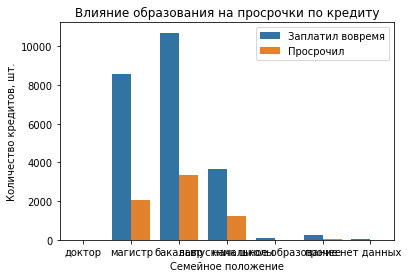

In [30]:
sns.countplot(x='EDUCATION', hue='default', data=data);
plt.xlabel('Семейное положение')
plt.xticks(np.arange(len(data_education.index)), ('доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных'))
plt.ylabel('Количество кредитов, шт.')
plt.title('Влияние образования на просрочки по кредиту')
plt.legend(['Заплатил вовремя', 'Просрочил'])

In [31]:
chi2_edu =stats.chi2_contingency(data_education)
print('Хи-квадрат равен: ', chi2_edu[0])
print('P-value: ', chi2_edu[1])
print('Ожидаемые значения: ',  chi2_edu[3])

Хи-квадрат равен:  163.21655786997073
P-value:  1.2332626245415605e-32
Ожидаемые значения:  [[1.0903200e+01 3.0968000e+00]
 [8.2435980e+03 2.3414020e+03]
 [1.0926564e+04 3.1034360e+03]
 [3.8293596e+03 1.0876404e+03]
 [9.5792400e+01 2.7207600e+01]
 [2.1806400e+02 6.1936000e+01]
 [3.9718800e+01 1.1281200e+01]]


Значение p-value равно 1.23e-32, что позволяет отклонить Н0. 
Следовательно, образование влияет на выплату кредита.

Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. 

In [32]:
data_education_expected = pd.DataFrame(chi2_edu[3].round(0))
data_education_expected.index = ['доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных']
data_education_expected.columns = ['Вернул', 'Просрочил']
data_education_expected

,Вернул,Просрочил
доктор,11.0,3.0
магистр,8244.0,2341.0
бакалавр,10927.0,3103.0
выпускник школы,3829.0,1088.0
начальное образование,96.0,27.0
прочее,218.0,62.0
нет данных,40.0,11.0


Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? 

In [33]:
data_edu_dif = pd.concat([data_education, data_education_expected, data_education - data_education_expected ], axis = 1)
data_edu_dif.columns = ['Вернул_Факт', 'Просрочил_Факт', 'Вернул_Ожид', 'Просрочил_Ожид', 'Вернул_Откл', 'Просрочил_Откл']
data_edu_dif = data_edu_dif[[ 'Вернул_Ожид', 'Вернул_Факт','Вернул_Откл', 'Просрочил_Ожид', 'Просрочил_Факт', 'Просрочил_Откл']]
data_edu_dif

,Вернул_Ожид,Вернул_Факт,Вернул_Откл,Просрочил_Ожид,Просрочил_Факт,Просрочил_Откл
доктор,11.0,14,3.0,3.0,0,-3.0
магистр,8244.0,8549,305.0,2341.0,2036,-305.0
бакалавр,10927.0,10700,-227.0,3103.0,3330,227.0
выпускник школы,3829.0,3680,-149.0,1088.0,1237,149.0
начальное образование,96.0,116,20.0,27.0,7,-20.0
прочее,218.0,262,44.0,62.0,18,-44.0
нет данных,40.0,43,3.0,11.0,8,-3.0


# 4. Семейное положение

Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

In [34]:
data_marriage = pd.crosstab(data.MARRIAGE, data.default)
data_marriage.index = ['отказываюсь', 'брак', 'холост', 'неизвестно']
data_marriage.columns = ['вернул', 'просрочил']
data_marriage

,вернул,просрочил
отказываюсь,49,5
брак,10453,3206
холост,12623,3341
неизвестно,239,84


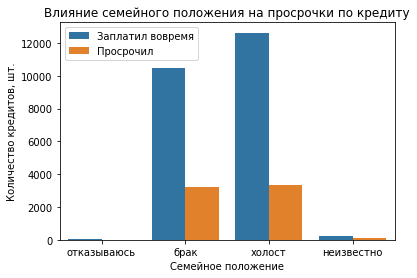

In [35]:
sns.countplot(x='MARRIAGE', hue='default', data=data);
plt.xlabel('Семейное положение')
plt.xticks(np.arange(len(data_marriage.index)), ('отказываюсь', 'брак', 'холост', 'неизвестно'))
plt.ylabel('Количество кредитов, шт.')
plt.title('Влияние семейного положения на просрочки по кредиту')
plt.legend(['Заплатил вовремя', 'Просрочил'])

 $H_0\colon$ Семейное положение не влияет на выплату кредита (выборки образования - независимы),
 
 $H_1\colon$ Семейное положение влияет на выплату кредита (выборки зависимы).

In [36]:
chi2_marriage =stats.chi2_contingency(data_marriage)
print('Хи-квадрат равен: ', chi2_marriage[0])
print('P-value: ', chi2_marriage[1])
print('Ожидаемые значения: ',  chi2_marriage[3])

Хи-квадрат равен:  35.66239583433609
P-value:  8.825862457577375e-08
Ожидаемые значения:  [[4.20552000e+01 1.19448000e+01]
 [1.06376292e+04 3.02137080e+03]
 [1.24327632e+04 3.53123680e+03]
 [2.51552400e+02 7.14476000e+01]]


Значение p-value равно 8.82e-08, что позволяет отклонить Н0. Следовательно, семейное положение влияет на выплату кредита.

# 5. Возраст 

Text(0.5,1,'Кредиты, в которых есть просрочки по возврату')

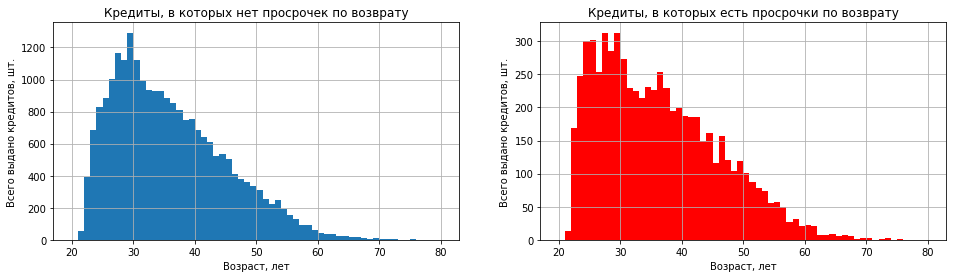

In [37]:
pylab.figure(figsize(16, 4))
pylab.subplot(1,2,1)
good_clients.AGE.hist(bins = 60, range = (20, 80))
pylab.xlabel('Возраст, лет')
pylab.ylabel('Всего выдано кредитов, шт.')
plt.title('Кредиты, в которых нет просрочек по возврату')

pylab.subplot(1,2,2)
bad_clients.AGE.hist(color='red', bins = 60, range = (20, 80))
pylab.xlabel('Возраст, лет')
pylab.ylabel('Всего выдано кредитов, шт.')
plt.title('Кредиты, в которых есть просрочки по возврату')


### a) Относительно двух групп людей вернувших и не вернувших кредит проверьте гипотезу о равенстве медианных значений возрастов людей. 

 $H_0\colon$ Семейное положение не влияет на выплату кредита (выборки образования - независимы),
 
 $H_1\colon$ Семейное положение влияет на выплату кредита (выборки зависимы).

In [38]:
good_clients_age_median =list(map(np.median, get_bootstrap_samples(good_clients.AGE.values, 1000)))
bad_clients_age_median =list(map(np.median, get_bootstrap_samples(bad_clients.AGE.values, 1000)))

In [39]:
diff_age_median = list(map(lambda x: x[0] - x[1], zip(good_clients_age_median, bad_clients_age_median)))

In [40]:
print ("95% довер. интервал медианы возраста для хороших клиентов: ",  stat_intervals(good_clients_age_median, 0.05))
print ("95% довер. интервал медианы возраста лимита для плохих клиентов:",  stat_intervals(bad_clients_age_median, 0.05))
print ("95% довер. интервал для разности медиан возраста для плохих и хороших клиентов:",  stat_intervals(diff_age_median, 0.05))

95% довер. интервал медианы возраста для хороших клиентов:  [34. 34.]
95% довер. интервал медианы возраста лимита для плохих клиентов: [34. 35.]
95% довер. интервал для разности медиан возраста для плохих и хороших клиентов: [-1.  0.]


Не можем отклонить Н0, т.к. доверительный интервал для разности содержит 0.

### b) Равны ли распределения в обоих группах?

Для проверки воспользуемся критерием Манна-Уитни для независимых выборок.

 $H_0\colon$ Распределения возрастов хороших и плохих клиентов равны.
 
 $H_1\colon$ Не равны.

In [41]:
stats.mannwhitneyu(good_clients.AGE.values, bad_clients.AGE.values)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

pvalue равно 0,18. Не можем отвергуть Н0 на уровне значимости 0,05
Доверительный интервал содержит ноль и p-value > 0,05. Следовательно, мы можем отвергунть Н0. 